In [1]:
%load_ext metapack
%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import matplotlib.pyplot as plt
import seaborn as sns
from sdipylib.geo import *
sns.set(color_codes=True)

from pkg_resources import get_distribution
assert get_distribution('publicdata').version >= '0.1.3'


# Basic CRA Demographics Analysis Example

This notebook is a demonstration of how to combine FFIEC records of business loans with census data and display the data in a variety of type of maps. The demonstration will cover using Metatab and Metapack to access data, creating maps with GeoPandas, and creating zoomable maps with a basemap using folium. 

This demonstration will focus on mapping, so if you'd like a more complete tutorial on using Metapack and Census data, please refer to the [American Community Survey tutorial notebook.](http://kb.sandiegodata.org/notebooks/american-community-survey-demonstration/)

First, we'll add a Metatab configuration that defines the references to the data we'll use, which include: 

* An ACS Table for counts of people by race in tracts in San Diego county
* Tract grographic boundaries for San DIego County
* A Metapack package for CRA Business loan originations. 

The  [American Community Survey tutorial notebook.](http://kb.sandiegodata.org/notebooks/american-community-survey-demonstration/) has more information about the structure of the Metatab configuration, and the CRA Loan dataset is available in a friendly form at the [Data Library's data repository](http://data.sandiegodata.org/dataset/ffiec-gov-cra_aggregate_smb-orig).

Note that to run this notebook, you will need to install these python packages:

```
jupyter
pandas
geopandas
matplotlib
seaborn
publicdata
```

In [2]:
%%metatab

    
Dataset: cra_mapping
Origin: sandiegodata.org
Version: 1

Section: Contacts
Wrangler: Eric Busboom
Wrangler.Email: eric@sandiegodata.org
Wrangler.Organization: San Diego Regional Data Library
  
Section: References

Reference: censusreporter:B02001/140/05000US06073
Reference.Name: B02001
Reference.Description: Table B02001: Race, by tract, in San Diego County

Reference: censusreportergeo://B02001/140/05000US06073
Reference.Name: B02001g
Reference.Description: Table B02001: Race, by tract, in San Diego County

Reference: metapack+http://library.metatab.org/ffiec.gov-cra_aggregate_smb-orig-4.csv#sb_agg_loan_orig
Reference.Name: agg_loan_orig
Reference.Description: CRA Loan originations, aggregated to tracts.
    

# Getting Started: Processing Data

Generally, the first parts of a Notebook should contain all of the data manipulations to get data sets combined, or or create new columns, and the the remainer of the notebook is the analysis. So, we will start by extracting data frames from the Metatab configuration. Recall from the  [American Community Survey tutorial notebook.](http://kb.sandiegodata.org/notebooks/american-community-survey-demonstration/)  that the ``%metatab`` cell creates the ``mt_pkg`` package variable, and from that package we can extract dataframes, for census data, and geoframes for geographic data.  


In [24]:
# The mt_pkg var is created by the %%metatab magic. 
# The B02001 and B02001g frames have the same data, but B02001 is a CensusDataFrame and B02001g is a GeoDataFrame
B02001 = mt_pkg.reference('B02001').dataframe().set_index('geoid')
B02001g = mt_pkg.reference('B02001g').geoframe().set_index('geoid')


Because the URL of the data frame ``B02001`` is special ( the ``censusreporter:`` scheme is defined in the ``publicdata`` package ) the resulting dataframe is of type ``publicdata.censusreporter.dataframe.CensusDataFrame``, it has a lot of special features, including a ``.title`` property that expands the column names to be more sensible. This view makes it easier to figure out what columns to incorporate in later analysis. 

In [26]:
B02001.titles.head(2).T

geoid,14000US06073000100,14000US06073000201
name,14000US06073000100,14000US06073000201
B02001001 Total,2716,2223
Margins for B02001001 Total,206,260
B02001002 Total White alone,2549,1983
Margins for B02001002 Total White alone,188,276
B02001003 Total Black or African American alone,0,27
Margins for B02001003 Total Black or African American alone,12,42
B02001004 Total American Indian and Alaska Native alone,0,7
Margins for B02001004 Total American Indian and Alaska Native alone,12,12
B02001005 Total Asian alone,60,95


In this case, we're going to create new variables for "Minority" and "Non Minority" where "Non Minority" is defined as White and Asian. 

In [5]:
B02001['white_asian'], B02001['white_asian_m90'] = B02001.sum_m('B02001002', 'B02001005')
B02001['minority'] = B02001.B02001001 - B02001.white_asian
B02001['non_min_r'], B02001['non_min_r_m90'] = B02001.ratio('white_asian', 'B02001001')

For the loan data, let's drop all of the records that are nulls, select only tract records,  and select only the year 2015. 

In [6]:
loans_r = mt_pkg.reference('agg_loan_orig')
loans = loans_r.read_csv()

loans = loans.dropna(subset=['geoid']).dropna(subset=['tract']).set_index('geoid')

# Note! Only one Year!
loans = loans[loans.year == 2015]


In [7]:
loans_r

Header,Type,Description
tableid,string,Table ID
year,number,Activity Year
type,number,Loan Type
action,number,Action Taken Type
state,string,State
county,string,County
msa,string,MSA/MD
tract,string,Census Tract
split_county,string,Split County Indicator
pop_class,string,Population Classification


Next, we can join the ACS, geographic, and loans dataframes. Previously, they were all given ``geoid`` for an index, so joining them is easy. Once they are joined, we can create some summary and derived columns. Note that the geographic dataset is joined first. This is important, because it means that the final ``df`` will also be a geographic dataframe. 

In [10]:
df = B02001g[['geometry']].join(B02001[['non_min_r']]).join(loans)

df['number_loans'] = df.number_lt100 + df.number_100_250 + df.number_250_1m
df['total_value'] = df.total_lt100 + df.total_100_250 + df.total_250_1m
df['mean_value'] = df.total_value + df.number_loans
df['loans_per_pop'] = df.number_loans / B02001.B02001001
df['loans_per_min'] = df.number_loans / B02001.minority
df['loan_val_per_pop'] = df.total_value / B02001.B02001001
df['loan_val_per_min'] = df.total_value / B02001.minority

geopandas.geodataframe.GeoDataFrame

In [27]:
df.head(3).T

geoid,14000US06073000100,14000US06073000201,14000US06073000202
geometry,"POLYGON ((-117.194904 32.75278, -117.19471 32....","POLYGON ((-117.178867 32.75765, -117.177966 32...","POLYGON ((-117.184043 32.74571, -117.183827 32..."
non_min_r,0.960604,0.934773,0.932522
non_min_r_m90,0.101467,0.168156,0.129733
tableid,A1-1,A1-1,A1-1
year,2015,2015,2015
type,4,4,4
action,1,1,1
state,6,6,6
county,73,73,73
msa,41740,41740,41740


# Creating Maps


Just as ``Metapack`` and the  ``publicdata`` module worked together to turn the dataset references by the ``censusreporter:`` reference into a special Census data frame, the ``censusreportergeo:`` reference returns a Geopandas dataframe. Geopandas has a built in support for geographic operations, such as creating maps. For instance:

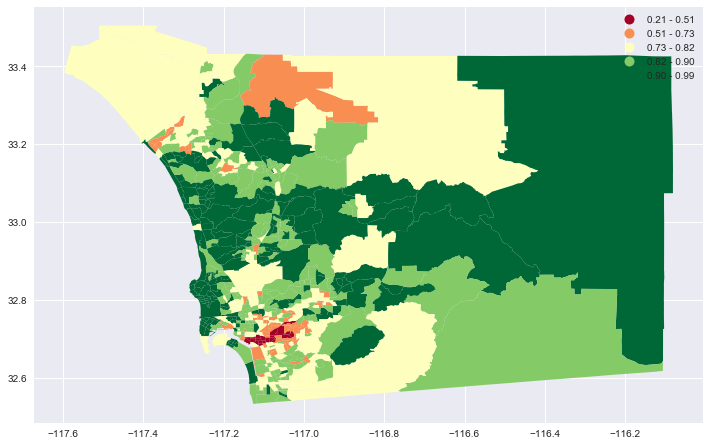

In [29]:
# Create the matplotlib figure and a single axis, and set the figure size
# to 12 inches wide, with the same aspect ratio as the geographic dataframe. This
# keeps the map from looking distored. 
fig, ax = aspect_fig_size(df, 12) 

_ = df.dropna(subset=['non_min_r'])

_.plot(ax=ax, column='non_min_r', cmap='RdYlGn',scheme='fisher_jenks', legend=True);

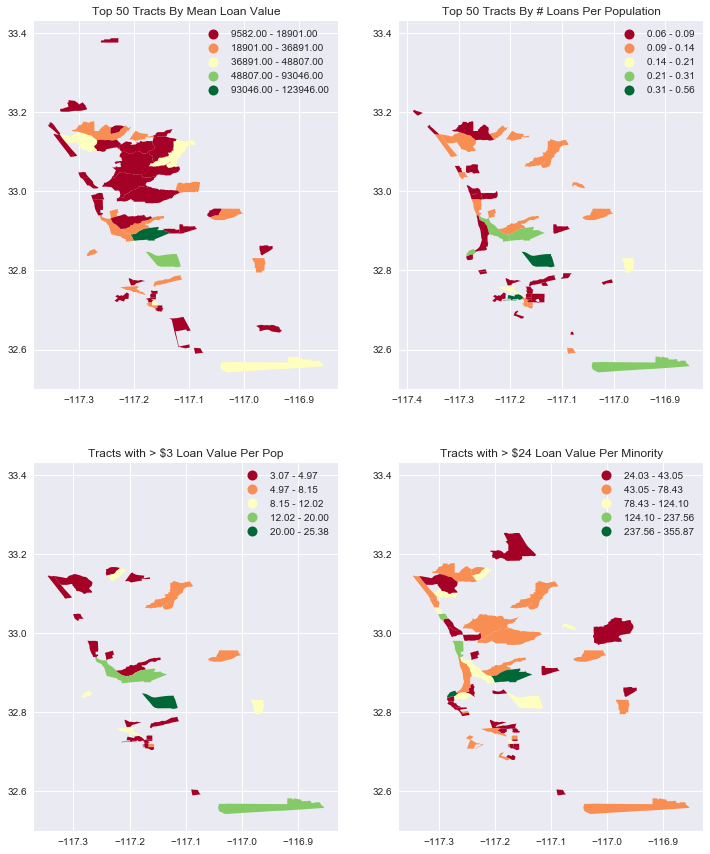

In [30]:
from sdipylib.geo import aspect 


# In this case, with multiple axes per figure, setting the aspect ratio is more manual
w = 6
a = max(aspect(_mv),aspect(_lpp))

fig = plt.figure(figsize = (2*w, 2*(w/a)))

# Doing ax2 first because it has the longer y axis, and want both plots to have the same
# y axis
ax2= fig.add_subplot(2,2,2)
_ = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['loans_per_pop'])\
    .sort_values('loans_per_pop', ascending=False).iloc[:50]
_.plot(ax=ax2, column='loans_per_pop', cmap='RdYlGn',scheme='fisher_jenks', legend=True)
ax2.set_title("Top 50 Tracts By # Loans Per Population")

# subplot(nrows, ncols, plot_number)
ax1= fig.add_subplot(2,2,1, sharey=ax2)
_ = df.dropna(subset=['mean_value']).sort_values('mean_value', ascending=False).iloc[:50]

_.plot(ax=ax1, column='mean_value', cmap='RdYlGn',scheme='fisher_jenks', legend=True)
ax1.set_title("Top 50 Tracts By Mean Loan Value")

ax3= fig.add_subplot(2,2,3, sharey=ax2)
_ = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['loan_val_per_pop'])
_ = _[_.loan_val_per_pop>3]
_.plot(ax=ax3, column='loan_val_per_pop', cmap='RdYlGn',scheme='fisher_jenks', legend=True)
ax3.set_title("Tracts with > $3 Loan Value Per Pop")

ax4= fig.add_subplot(2,2,4, sharey=ax2)
_ = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['loan_val_per_min'])
_ = _[_.loan_val_per_min>24]
_.plot(ax=ax4, column='loan_val_per_min', cmap='RdYlGn',scheme='fisher_jenks', legend=True)
ax4.set_title("Tracts with > $24 Loan Value Per Minority");

Geopandas mapping is really easy, but it is hard to tell where the tracts are, because there is no base map. The folium module links Geopandas and Leaflet, and lets us put choropleth maps on a scrollable, zoomable map. 

In [14]:

_ = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['loan_val_per_pop'])
_ = _[_.loan_val_per_pop>3]
folium_map(_,'loan_val_per_pop', zoom_start=10, fill_color='YlGn', fill_opacity=.7)

In [15]:
_ = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['loans_per_pop'])
_ = _.sort_values('loans_per_pop', ascending=False).iloc[:100] # don't exceed notebooks IOPub data rate
#_ = _[_.loan_val_per_pop>3]
folium_map(_,'loans_per_pop', zoom_start=10, fill_color='YlGn', fill_opacity=.7)

# Focus on Minority Areas with Radius Searches

Next, we'll locate an area with a high portion of minorities and focus on the nearby area. By sorting on the ``non_min_r`` ( Non-minority ratio ) and selecting the bottom 20 values, we can union the tracts, find the center, and then use that as the center for a minority cluster. 

Using Geopandas, we can use plot the bottom 20 tracts to get a quick view of the area. 

[-117.150228   32.682374 -117.010391   32.753434]


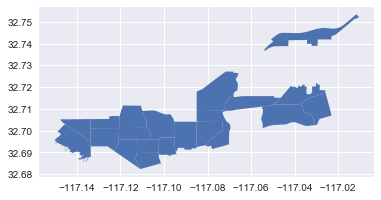

In [16]:
# Find the top 30 highest minority areas and plot as a seperate set. They are fairly 
# geographically clustered
_ = df.sort_values('non_min_r').iloc[:20]
_.plot()


Next, compute the distance from the minority center to the centroid of all other tracts. We'll use this value to constrain the radius search. The resulting distances are in meters. 

In [17]:
# Get the center point of the high-minority areas. The unary_union is required
# because the subsequence operations work on individual shapes, so we have to join the shapes first. 
minority_center = df.sort_values('non_min_r').iloc[:20].unary_union.convex_hull.centroid

#
# Then compute the distance of each other the remaining tracts to 
# the high minority centroid. 
df['minr_dist_deg'] = df.geometry.distance(minority_center)

import pyproj
from functools import partial

geod = pyproj.Geod(ellps='WGS84')
def geodetic_dist(point1, region2):
    """Returns the distance between a point and the centroid of a region in meters"""
    point2 = region2.centroid
    angle1,angle2,distance = geod.inv(point1.x, point1.y, point2.x, point2.y)
    return distance

# Note that this distance will tend to exclude large tracts, because the centroids are relatively farther away. 
df['minr_dist_m'] =df.geometry.apply(partial(geodetic_dist, minority_center))



Then, we just need to constrain the ``minr_dist_m`` to get our cluster. 

In [ ]:
min_areas = df[ df.minr_dist_m < 7000].dropna(subset=['non_min_r'])
min_areas = min_areas.dropna(subset=['non_min_r'])

Ploting is easy, as before, but this time we'll also add a large blue dot to marl the location of the centroid. 

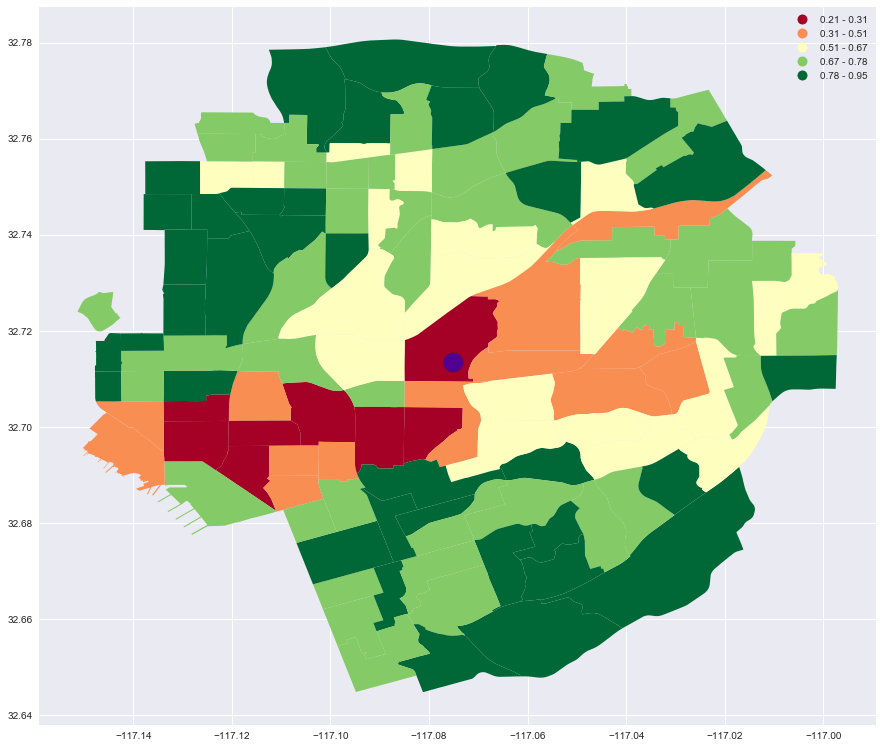

In [20]:
fig, ax = aspect_fig_size(min_areas, 15)

min_areas.plot(ax=ax, column='non_min_r', cmap='RdYlGn',scheme='fisher_jenks', legend=True)


# Plot the minority centroid point, with a bit of a buffer to make it larger
import descartes 
circle = minority_center.buffer(.002)
ax.add_patch(descartes.PolygonPatch(circle, fc='blue', alpha=0.5));

And, of course, it is easier to visualize where this cluster is when it is laid over a street map. 

In [21]:
folium_map(min_areas,'non_min_r')